In [1]:
import pickle
import json
import redshift_connector
import pandas as pd
pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 200)
import numpy as np
import unidecode
import re

from collections import Counter
from math import ceil
from langdetect import detect

In [27]:
# Redshift credentials for querying the OpenAlex database
with open("redshift_creds.txt", "r") as f:
    host = f.readline()[:-1]
    password= f.readline()[:-1]

In [28]:
# Creating a connection
conn = redshift_connector.connect(
     host=host,
     database='dev',
     user='app_user',
     password=password
  )

cursor = conn.cursor()

## Exploring the ROR Data to Create Artificial Training Data

In [24]:
# Data was downloaded from the ROR website for the date seen in the file string below
# -------> https://ror.readme.io/docs/data-dump
ror = pd.read_json("../v1.0-2022-03-17-ror-data.json")

In [47]:
ror['alias_len'] = ror['aliases'].apply(len)
ror['acronyms_len'] = ror['acronyms'].apply(len)
ror['labels_len'] = ror['labels'].apply(len)
ror['address_len'] = ror['addresses'].apply(len)
ror['address'] = ror['addresses'].apply(lambda x: x[0])
ror['ror_id'] = ror['id'].apply(lambda x: x.split("/")[-1])

In [188]:
ror[ror['ror_id']=='01a1mq059']

,id,name,types,links,aliases,acronyms,status,wikipedia_url,labels,email_address,ip_addresses,established,country,relationships,addresses,external_ids,alias_len,acronyms_len,labels_len,ror_id,address_len,address
47879,https://ror.org/01a1mq059,ARC Centre of Excellence in Plant Energy Biology,[Facility],[http://www.plantenergy.uwa.edu.au/],[],[PEB],active,,[],None,[],NaN,"{'country_code': 'AU', 'country_name': 'Australia'}","[{'type': 'Parent', 'label': 'Australian National University', 'id': 'https://ror.org/019wvm592'}, {'type': 'Parent', 'label': 'Australian Research Council', 'id': 'https://ror.org/05mmh0f86'}]","[{'line': None, 'lat': -31.983877, 'lng': 115.815613, 'postcode': None, 'primary': False, 'city': 'Perth', 'state': 'Western Australia', 'state_code': 'AU-WA', 'country_geonames_id': 2077456, 'geonames_city': {'id': 2063523, 'city': 'Perth', 'nuts_level1': {'code': None, 'name': None}, 'nuts_level2': {'code': None, 'name': None}, 'nuts_level3': {'code': None, 'name': None}, 'geonames_admin1': {'id': 2058645, 'name': 'Western Australia', 'ascii_name': 'Western Australia', 'code': 'AU.08'}, 'geonames_admin2': {'id': 2063522, 'name': 'City of Perth', 'ascii_name': 'City of Perth', 'code': 'AU.08.57080'}, 'license': {'attribution': 'Data from geonames.org under a CC-BY 3.0 license', 'license': 'http://creativecommons.org/licenses/by/3.0/'}}}]","{'ISNI': {'preferred': None, 'all': ['0000 0004 0611 8771']}, 'FundRef': {'preferred': None, 'all': ['501100006067']}, 'GRID': {'preferred': 'grid.457375.7', 'all': 'grid.457375.7'}}",0,1,0,01a1mq059,1,"{'line': None, 'lat': -31.983877, 'lng': 115.815613, 'postcode': None, 'primary': False, 'city': 'Perth', 'state': 'Western Australia', 'state_code': 'AU-WA', 'country_geonames_id': 2077456, 'geonames_city': {'id': 2063523, 'city': 'Perth', 'nuts_level1': {'code': None, 'name': None}, 'nuts_level2': {'code': None, 'name': None}, 'nuts_level3': {'code': None, 'name': None}, 'geonames_admin1': {'id': 2058645, 'name': 'Western Australia', 'ascii_name': 'Western Australia', 'code': 'AU.08'}, 'geonames_admin2': {'id': 2063522, 'name': 'City of Perth', 'ascii_name': 'City of Perth', 'code': 'AU.08.57080'}, 'license': {'attribution': 'Data from geonames.org under a CC-BY 3.0 license', 'license': 'http://creativecommons.org/licenses/by/3.0/'}}}"


In [245]:
ror_to_join = ror[['ror_id','name','aliases','acronyms','labels','country',
                   'address','alias_len','acronyms_len','labels_len','address_len']].copy()

In [246]:
def get_geoname_admin(address_dict):
    """
    Trying to get geoname from ROR if it exists.
    """
    try:
        geoname_admin = address_dict['geonames_city']['geonames_admin1']['name']
    except:
        geoname_admin = "None"
        
    return geoname_admin

In [247]:
ror_to_join['country_code'] = ror_to_join['country'].apply(lambda x: x['country_code'])
ror_to_join['country_name'] = ror_to_join['country'].apply(lambda x: x['country_name'])
ror_to_join['city'] = ror_to_join['address'].apply(lambda x: x['city'])
ror_to_join['state'] = ror_to_join['address'].apply(lambda x: x['state'])
ror_to_join['region'] = ror_to_join['address'].apply(get_geoname_admin)
ror_to_join['institution'] = ror_to_join['name']

In [248]:
ror_to_join[ror_to_join['country_name']=='China'].sample(5)

,ror_id,name,aliases,acronyms,labels,country,address,alias_len,acronyms_len,labels_len,address_len,country_code,country_name,city,state,region,institution
5757,01cxqmw89,Shanghai Normal University,[],[SHNU],"[{'label': '上海师范大学', 'iso639': 'zh'}]","{'country_code': 'CN', 'country_name': 'China'}","{'line': None, 'lat': 31.161529, 'lng': 121.416487, 'postcode': None, 'primary': False, 'city': 'Shanghai', 'state': None, 'state_code': None, 'country_geonames_id': 1814991, 'geonames_city': {'id': 1796236, 'city': 'Shanghai', 'nuts_level1': {'code': None, 'name': None}, 'nuts_level2': {'code': None, 'name': None}, 'nuts_level3': {'code': None, 'name': None}, 'geonames_admin1': {'id': 1796231, 'name': 'Shanghai', 'ascii_name': 'Shanghai', 'code': 'CN.23'}, 'geonames_admin2': {'id': None, 'name': None, 'ascii_name': None, 'code': None}, 'license': {'attribution': 'Data from geonames.org under a CC-BY 3.0 license', 'license': 'http://creativecommons.org/licenses/by/3.0/'}}}",0,1,1,1,CN,China,Shanghai,None,Shanghai,Shanghai Normal University
50613,03j93xk55,Zhejiang Hisun Pharmaceutical (China),[],[],[],"{'country_code': 'CN', 'country_name': 'China'}","{'line': None, 'lat': 28.662358, 'lng': 121.424512, 'postcode': None, 'primary': False, 'city': 'Taizhou', 'state': None, 'state_code': None, 'country_geonames_id': 1814991, 'geonames_city': {'id': 8400694, 'city': 'Taizhou', 'nuts_level1': {'code': None, 'name': None}, 'nuts_level2': {'code': None, 'name': None}, 'nuts_level3': {'code': None, 'name': None}, 'geonames_admin1': {'id': 1784764, 'name': 'Zhejiang', 'ascii_name': 'Zhejiang', 'code': 'CN.02'}, 'geonames_admin2': {'id': None, 'name': None, 'ascii_name': None, 'code': None}, 'license': {'attribution': 'Data from geonames.org under a CC-BY 3.0 license', 'license': 'http://creativecommons.org/licenses/by/3.0/'}}}",0,0,0,1,CN,China,Taizhou,None,Zhejiang,Zhejiang Hisun Pharmaceutical (China)
54794,00qzhtm25,Fairy Lake Botanical Garden,[Xianhu Botanical Garden],[FLBG],"[{'label': '仙湖植物园', 'iso639': 'zh'}]","{'country_code': 'CN', 'country_name': 'China'}","{'line': None, 'lat': 22.582523, 'lng': 114.169965, 'postcode': None, 'primary': False, 'city': 'Shenzhen', 'state': None, 'state_code': None, 'country_geonames_id': 1814991, 'geonames_city': {'id': 1795565, 'city': 'Shenzhen', 'nuts_level1': {'code': None, 'name': None}, 'nuts_level2': {'code': None, 'name': None}, 'nuts_level3': {'code': None, 'name': None}, 'geonames_admin1': {'id': 1809935, 'name': 'Guangdong', 'ascii_name': 'Guangdong', 'code': 'CN.30'}, 'geonames_admin2': {'id': 1795563, 'name': 'Shenzhen', 'ascii_name': 'Shenzhen', 'code': 'CN.30.4403'}, 'license': {'attribution': 'Data from geonames.org under a CC-BY 3.0 license', 'license': 'http://creativecommons.org/licenses/by/3.0/'}}}",1,1,1,1,CN,China,Shenzhen,None,Guangdong,Fairy Lake Botanical Garden
72489,05m0z0h30,Nano and Advanced Materials Institute,[],[NAMI],[],"{'country_code': 'CN', 'country_name': 'China'}","{'line': None, 'lat': 22.3351208, 'lng': 114.2639964, 'postcode': None, 'primary': False, 'city': 'Hong Kong', 'state': 'Hong Kong', 'state_code': 'CN-91', 'country_geonames_id': 1814991, 'geonames_city': {'id': 1819729, 'city': 'Hong Kong', 'nuts_level1': {'code': None, 'name': None}, 'nuts_level2': {'code': None, 'name': None}, 'nuts_level3': {'code': None, 'name': None}, 'geonames_admin1': {'id': 7533598, 'name': 'Central and Western', 'ascii_name': 'Central and Western', 'code': 'HK.HCW'}, 'geonames_admin2': {'id': None, 'name': None, 'ascii_name': None, 'code': None}, 'license': {'attribution': 'Data from geonames.org under a CC-BY 3.0 license', 'license': 'http://creativecommons.org/licenses/by/3.0/'}}}",0,1,0,1,CN,China,Hong Kong,Hong Kong,Central and Western,Nano and Advanced Materials Institute
34463,02wmsc916,Guizhou University,[Guìzhōu Dàxué],[],"[{'label': '贵州大学', 'iso639': 'zh'}]","{'country_code': 'CN', 'country_name': 'China'}","{'line': None, 'lat': 26.420439000000002, 'lng': 106.671107,

In [249]:
ror_to_join[['alias_len','acronyms_len','labels_len','address_len']].describe()

,alias_len,acronyms_len,labels_len,address_len
count,102559.000000,102559.000000,102559.000000,102559.0
mean,0.237034,0.419017,0.265389,1.0
std,0.523681,0.532959,0.508385,0.0
min,0.000000,0.000000,0.000000,1.0
25%,0.000000,0.000000,0.000000,1.0
50%,0.000000,0.000000,0.000000,1.0
75%,0.000000,1.000000,0.000000,1.0
max,8.000000,10.000000,10.000000,1.0


#### Looking at ROR labels

In [250]:
# language codes that would be difficult for a model to predict
codes_to_ignore = ['ja','fa','hi','ko','bn','zh','ml','ru','el','kn','gu','mk','ne','te','hy',
                   'km','ti','kk','th','my','uk','pa','bg','ur','vi','ar','sr','he','ta','ka',
                   'am','mr','lo','mn','be','or','ba','si','ky','uz']

In [251]:
labels = ror_to_join['labels'].explode().dropna().reset_index()
labels['label'] = labels['labels'].apply(lambda x: x['label'])
labels['iso639'] = labels['labels'].apply(lambda x: x['iso639'])

In [252]:
labels[~labels['iso639'].isin(codes_to_ignore)].sample(20)

,index,labels,label,iso639
4324,6648,"{'label': 'Catharina Hospital', 'iso639': 'en'}",Catharina Hospital,en
6223,12959,"{'label': 'Ministério da Saúde', 'iso639': 'pt'}",Ministério da Saúde,pt
8648,32234,"{'label': 'Universidad Salesiana', 'iso639': 'es'}",Universidad Salesiana,es
19245,71776,"{'label': 'Genetikai Intézet Szegedi Biológiai Kutatóközpont Magyar Tudományos Akadémia', 'iso639': 'hu'}",Genetikai Intézet Szegedi Biológiai Kutatóközpont Magyar Tudományos Akadémia,hu
576,550,"{'label': 'Università degli Studi Roma Tre', 'iso639': 'it'}",Università degli Studi Roma Tre,it
20409,78667,"{'label': 'Institut de Recherche Technologique B-com', 'iso639': 'fr'}",Institut de Recherche Technologique B-com,fr
26360,100090,"{'label': 'Laboratoire de Mécanique des Contacts et des Structures', 'iso639': 'fr'}",Laboratoire de Mécanique des Contacts et des Structures,fr
6421,16094,"{'label': 'Chambre de Commerce et d'industrie de Paris', 'iso639': 'fr'}",Chambre de Commerce et d'industrie de Paris,fr
1590,1618,"{'label': 'Université de Nîmes', 'iso639': 'fr'}",Université de Nîmes,fr
23250,86482,"{'label': 'Meabhairshláinte na hÉireann', 'iso639': 'ga'}",Meabhairshláinte na hÉireann,ga


#### Easy attempt at creating artificial string

We would like to take advantage of the ROR data and use it to supplement/augment the current affiliation string data in OpenAlex. This could potentially allow for the Institution Tagger model to predict on institutions that have not yet had affiliation strings added to OpenAlex.

In [362]:
def create_affiliation_string_from_scratch(institution, city, state, country, region, aliases, labels, acronyms):
    """
    This function takes in all of the ROR data for a specific ROR ID and outputs some artificial
    data that can be used to augment the OpenAlex affiliation string data that will be used in
    training the models.
    """
    aff_strings = []
    if aliases:
        aliases = [institution] + aliases
    else:
        aliases = [institution]
    
    # Add in labels if available (and in a language not in the 'codes_to_ignore' language list)
    if labels:
        for label in labels:
            if label['iso639'] in codes_to_ignore:
                pass
            else:
                aliases.append(label['label'])
                
    # Adds in acronyms if available
    if acronyms:
        for acronym in acronyms:
            aliases.append(acronym)
            
    # Iterates through all aliases, labels, and acronyms
    for alias in aliases:
        match_string = alias.lower().replace(" ", "")
        match_string = unidecode.unidecode(match_string)
        match_string = "".join(re.findall("[a-zA-Z0-9]+", match_string)) 
        alias = unidecode.unidecode(alias)
        # First try
        if ((state is None) & (region != city) & (city is not None) & 
            (country is not None) & (region is not None)):
            region = unidecode.unidecode(region)
            country = unidecode.unidecode(country)
            city = unidecode.unidecode(city)
            aff_strings.append([f"{alias}, {city}, {region}, {country}", match_string])
            aff_strings.append([f"{alias}, {city}, {country}", match_string])
            aff_strings.append([f"{alias}, {city}, {region}", match_string])
            aff_strings.append([f"{alias}, {country}", match_string])
            aff_strings.append([f"{alias}, {city}", match_string])
            aff_strings.append([f"{alias}, {region}", match_string])
            aff_strings.append([f"{alias} {city} {region} {country}", match_string])
            aff_strings.append([f"{alias} {city} {country}", match_string])
            aff_strings.append([f"{alias} {city} {region}", match_string])
            aff_strings.append([f"{alias} {country}", match_string])
            aff_strings.append([f"{alias} {city}", match_string])
            aff_strings.append([f"{alias} {region}", match_string])
            aff_strings.append([f"{alias}", match_string])
        # Second Try
        elif (state is not None) & (city is not None) & (country is not None):
            state = unidecode.unidecode(state)
            country = unidecode.unidecode(country)
            city = unidecode.unidecode(city)
            aff_strings.append([f"{alias}, {city}, {state}, {country}", match_string])
            aff_strings.append([f"{alias}, {city}, {country}", match_string])
            aff_strings.append([f"{alias}, {city}, {state}", match_string])
            aff_strings.append([f"{alias}, {country}", match_string])
            aff_strings.append([f"{alias}, {city}", match_string])
            aff_strings.append([f"{alias}, {state}", match_string])
            aff_strings.append([f"{alias} {city} {state} {country}", match_string])
            aff_strings.append([f"{alias} {city} {country}", match_string])
            aff_strings.append([f"{alias} {city} {state}", match_string])
            aff_strings.append([f"{alias} {country}", match_string])
            aff_strings.append([f"{alias} {city}", match_string])
            aff_strings.append([f"{alias} {state}", match_string])
            aff_strings.append([f"{alias}", match_string])
        # Third Try
        elif (city is not None) & (country is not None):
            country = unidecode.unidecode(country)
            city = unidecode.unidecode(city)
            aff_strings.append([f"{alias}, {city}, {country}", match_string])
            aff_strings.append([f"{alias}, {country}", match_string])
            aff_strings.append([f"{alias}, {city}", match_string])
            aff_strings.append([f"{alias} {city} {country}", match_string])
            aff_strings.append([f"{alias} {country}", match_string])
            aff_strings.append([f"{alias} {city}", match_string])
            aff_strings.append([f"{alias}", match_string])
        # Fourth Try
        elif (country is not None):
            country = unidecode.unidecode(country)
            aff_strings.append([f"{alias}, {country}", match_string])
            aff_strings.append([f"{alias} {country}", match_string])
            aff_strings.append([f"{alias}", match_string])
        # If all other tries fail, just append the alias on its own
        else:
            aff_strings.append([f"{alias}", match_string])
    return aff_strings

In [363]:
def get_institutions_list(institution, aliases, labels, acronyms):
    """
    Takes in ROR data and outputs aliases that could be used to create artificial strings.
    """
    aff_strings = []
    if aliases:
        aliases = [institution] + aliases
    else:
        aliases = [institution]
    
    # Add in labels if available (and in a language not in the 'codes_to_ignore' language list)
    if labels:
        for label in labels:
            if label['iso639'] in codes_to_ignore:
                pass
            else:
                aliases.append(label['label'])
    return aliases

In [364]:
# Getting the list of aliases and labels to use
ror_to_join['affs'] = ror_to_join \
.apply(lambda x: get_institutions_list(x.institution, x.aliases,
                                       x.labels, x.acronyms), axis=1)

# Getting the affiliation strings for each ROR ID
ror_to_join['aff_string'] = ror_to_join \
.apply(lambda x: create_affiliation_string_from_scratch(x.institution, x.city, x.state, 
                                                        x.country_name, x.region, 
                                                        x.aliases, x.labels, x.acronyms), axis=1)

# Creating a row for each artificial string
ror_to_join_final = ror_to_join[['ror_id','aff_string']].explode("aff_string").copy()

# Getting the affiliation string and the match string from the output column
ror_to_join_final['original_affiliation'] = ror_to_join_final['aff_string'].apply(lambda x: x[0])
ror_to_join_final['match_institution_name'] = ror_to_join_final['aff_string'].apply(lambda x: x[1])

# Saving the newly created data to a file so that it can be easily joined
# with the affiliation string data in another notebook
ror_to_join_final[['ror_id','original_affiliation','match_institution_name']] \
.to_parquet("ror_strings.parquet")

In [403]:
# Creating some artificial empty affiliations of just a city and a country because a string that
# only contained that information is not able to be predicted
art_empty_affs = ror_to_join[['city','country_name']].copy()

art_empty_affs['original_affiliation'] = art_empty_affs.apply(lambda x: f"{x.city}, {x.country_name}", axis=1)

art_empty_affs['original_affiliation'].value_counts().reset_index() \
.rename(columns={'original_affiliation':'count',
                 'index':'original_affiliation'}) \
.drop_duplicates(subset=['original_affiliation']).head(60).to_parquet("artificial_empty_affs.parquet")

### Following cells are used to find institutions based on name or ROR ID (for quality testing)

##### Search by name

In [342]:
match_str = "Drainage".lower()
print(inst[inst['display_name'].str.contains(match_str)].shape[0])
inst[inst['display_name'].str.contains(match_str)] \
[['display_name','affiliation_id','ror_id','city','region','country']] \
.sort_values('country') \
.iloc[:150]

4


,display_name,affiliation_id,ror_id,city,region,country
27105,beijing drainage group,4210145902,04pfhpy42,Beijing,None,China
47314,yukon river drainage fisheries association,4210152026,040rjhz75,Anchorage,Alaska,United States
38449,national water supply and drainage board,1341110861,None,None,None,None
59819,international commission on irrigation and drainage,1324109287,None,None,None,None


##### Search by ROR ID

In [35]:
ror_id = "045495t75"
print(inst[inst['ror_id']==ror_id].shape[0])
inst[inst['ror_id']==ror_id] \
[['display_name','affiliation_id','ror_id','city','region','country']]

1


,display_name,affiliation_id,ror_id,city,region,country
83588,ifo institute for economic research,1340728805,045495t75,Munich,None,Germany


In [167]:
country = "jhvkgv"
print(inst[inst['country']==country].shape[0])
inst[inst['country']==country] \
[['display_name','affiliation_id','ror_id','city','region','country']]

0


,display_name,affiliation_id,ror_id,city,region,country


In [214]:
country = 4210154800
print(inst[inst['affiliation_id']==country].shape[0])
inst[inst['affiliation_id']==country] \
[['display_name','affiliation_id','ror_id','city','region','country']]

1


,display_name,affiliation_id,ror_id,city,region,country
105777,olsztyńska szkoła wyższa im. józefa rusieckiego,4210154800,03yzt0f97,Olsztyn,None,Poland


## General Exploration

In [287]:
# Looking to see how many institutions don't have a ROR ID
query = """select count(*)
           from mid.institution 
           where ror_id is null"""

In [288]:
cursor.execute("ROLLBACK;")
cursor.execute(query)
counts = cursor.fetchall()
print(counts)

([6268],)


In [271]:
# Looking into a random sample of data in the institution table
query = """select affiliation_id, normalized_name, display_name, match_name, ror_id, city, 
                  region, country, geonames_city_id
           from mid.institution 
           order by RANDOM()
           limit 1000"""

In [272]:
cursor.execute("ROLLBACK;")
cursor.execute(query)
inst = cursor.fetch_dataframe()
inst['match_name'] = inst['match_name'] \
    .str.wrap(30).str.replace("\n", " ")
inst.shape

(1000, 9)

In [286]:
inst[inst['ror_id'].isnull()].sample(10)

,affiliation_id,normalized_name,display_name,match_name,ror_id,city,region,country,geonames_city_id
657,104245309,finch college,Finch College,finchcollege,None,None,None,None,None
945,1312301761,friends of the earth international,Friends of the Earth International,friendsoftheearthinternational,None,None,None,None,None
789,286735042,national defence university,National Defence University,nationaldefenceuniversity,None,None,None,None,None
212,1314580408,paradigm,Paradigm,paradigm,None,None,None,None,None
623,201344708,mercury marine,Mercury Marine,mercurymarine,None,None,None,None,None
812,873883488,newfield exploration,Newfield Exploration,newfieldexploration,None,None,None,None,None
322,138363959,prathyusha institute of technology and management,Prathyusha Institute of Technology and Management,prathyushainstituteoftechnolog yandmanagement,None,None,None,None,None
991,1341152391,the islamia university of bahawalpur pakistan,The Islamia University of Bahawalpur Pakistan,theislamiauniversityofbahawalp urpakistan,None,None,None,None,None
299,119233137,nicolaus copernicus university in torun,Nicolaus Copernicus University in Toruń,nicolauscopernicusuniversityin torun,None,None,None,None,None
980,211805567,beta,Beta,beta,None,None,None,None,None


In [284]:
inst.sample(10)

,affiliation_id,normalized_name,display_name,match_name,ror_id,city,region,country,geonames_city_id
615,2799406666,asian center for theological studies and mission,Asian Center for Theological Studies and Mission,asiancenterfortheologicalstudi esandmission,02q017026,Yangp'yŏng,None,South Korea,1832830
295,4210113896,qingdao national laboratory for marine science and technology,Qingdao National Laboratory for Marine Science and Technology,qingdaonationallaboratoryforma rinescienceandtechnology,026sv7t11,Qingdao,None,China,1797929
942,4210109605,dpartement sant animale,Département Santé Animale,departementsanteanimale,024409k12,Nouzilly,None,France,2989945
79,4210142259,innospec,Innospec,innospec,03ar2j538,Widnes,None,United Kingdom,2633954
739,4210098614,shanghai hi tech joint biotechnology r d,Shanghai Hi-Tech joint biotechnology R & D,shanghaihitechjointbiotechnolo gyrd,01485rp97,Shanghai,None,China,1796236
835,4210160659,tahirih justice center,Tahirih Justice Center,tahirihjusticecenter,04emmg248,Falls Church,Virginia,United States,4758390
924,4210155460,akita university of art,Akita University of Art,akitauniversityofart,0568p5n31,Akita,None,Japan,2113126
205,4210122469,center for atlantic oral surgery,Center for Atlantic Oral Surgery,centerforatlanticoralsurgery,026g21e16,Tinton Falls,New Jersey,United States,5105433
183,4210130622,max planck institute of molecular physiology,Max Planck Institute of Molecular Physiology,maxplanckinstituteofmolecularp hysiology,03vpj4s62,Dortmund,None,Germany,2935517
262,75354592,federal trade commission,Federal Trade Commission,federaltradecommission,02jpn1774,Washington D.C.,District of Columbia,United States,4140963


### Affiliations

In [137]:
query = """select count(*)
           from mid.affiliation"""

In [138]:
cursor.execute("ROLLBACK;")
cursor.execute(query)
counts = cursor.fetchall()
print(counts)

([572385239],)


In [27]:
query = """select a.paper_id, a.affiliation_id, a.original_affiliation, b.display_name, 
                  b.ror_id, b.city, b.region, b.country
           from (select paper_id, affiliation_id, original_affiliation
                 from mid.affiliation
                 where original_affiliation is not null and affiliation_id is not null
                 order by RANDOM()
                 limit 50000) a
           left join (select affiliation_id, display_name, ror_id, city, region, country 
                       from mid.institution) b
           on a.affiliation_id=b.affiliation_id
                 """

In [28]:
cursor.execute("ROLLBACK;")
cursor.execute(query)
affs = cursor.fetch_dataframe()
affs.columns

Index(['paper_id', 'affiliation_id', 'original_affiliation', 'display_name',
       'ror_id', 'city', 'region', 'country'],
      dtype='object')

In [29]:
affs.drop_duplicates(subset=['affiliation_id']).sample(1000).to_csv("gold_standard_1000_random.csv", index=None)

In [30]:
affs.sample(10)

,paper_id,affiliation_id,original_affiliation,display_name,ror_id,city,region,country
22653,2083235528,1174212,"Departments of Urology and Radiation Oncology, Norris Comprehensive Cancer Center, University of Southern California, Los Angeles, California",University of Southern California,03taz7m60,Los Angeles,California,United States
35509,2604740419,27945538,"Institute of Tendon & Bone Regeneration, Paracelsus Medical University Salzburg, Spinal Cord Injury and Tissue Regeneration Centre Salzburg, Salzburg, Austria",Paracelsus Medical University,03z3mg085,Salzburg,Salzburg,Austria
23787,2343874791,97565354,"Department of Ophthalmology, University of Lausanne. Jules-Gonin Eye Hospital. Fondation Asile des Aveugles, Avenue de France 15, CP 133 1000 Lausanne 7, Switzerland.",University of Lausanne,019whta54,Lausanne,None,Switzerland
34087,2110816157,169045520,"Departamento de Química, Universidade Federal da Paraíba, CCEN, João Pessoa, Brazil.",Federal University of Paraíba,00p9vpz11,João Pessoa,None,Brazil
48048,2603816253,142947616,"Clinical Trials and Statistics Unit, The Institute of Cancer Research, London, United Kingdom",Institute of Cancer Research,043jzw605,London,None,United Kingdom
1979,3204908715,1316054898,"Zavod za pedodonciju i preventivnu stomatologiju Sveučilišnoga stomatološkoga kliničkoga centra Kosova, 10 000 Priština, Kosovo",Centra,None,None,None,None
45538,3119259296,84218800,"School of Veterinary Medicine, University of California‐Davis USA","University of California, Davis",05rrcem69,Davis,California,United States
45382,2132079465,130828816,"Centre for Computational Fluid Dynamics, University of Leeds, Leeds LS2 9JT, U.K.",University of Leeds,024mrxd33,Leeds,None,United Kingdom
22237,3100417291,188973947,Novosibirsk State University,Novosibirsk State University,04t2ss102,Novosibirsk,None,Russia
32365,2903749363,194450716,"Department of Urology,the First Hospital of Jilin University,ChangChun 130021,China)",Jilin University,00js3aw79,Changchun,None,China


### Looking at Specific Paper

In [93]:
query = """select a.paper_id, a.affiliation_id, a.original_affiliation,
                 a.match_institution_name, b.normalized_name, b.display_name, 
                 b.match_name, b.ror_id, b.city, b.region, b.country, b.geonames_city_id
            from(select paper_id, affiliation_id, original_affiliation,
                 match_institution_name
                 from mid.affiliation 
                 where paper_id = 3127589655) a
            left join (select affiliation_id, normalized_name,display_name, 
                       match_name, ror_id, city, region, country, geonames_city_id
                       from mid.institution) b
           on a.affiliation_id=b.affiliation_id"""

In [94]:
cursor.execute("ROLLBACK;")
cursor.execute(query)
test_df = cursor.fetch_dataframe()
test_df.shape
test_df['match_institution_name'] = test_df['match_institution_name'] \
    .str.wrap(30).str.replace("\n", " ")
test_df['match_name'] = test_df['match_name'] \
    .str.wrap(30).str.replace("\n", " ")

In [95]:
test_df.drop_duplicates(subset=['affiliation_id']).head(10)

,paper_id,affiliation_id,original_affiliation,match_institution_name,normalized_name,display_name,match_name,ror_id,city,region,country,geonames_city_id
0,3127589655,1320721754,"Observation and Research Station of the Land Use and Ecological Succession in Huanghuaihai Coal Mining Area, Ministry of Natural Resources, Xuzhou, China",observationandresearchstationo fthelanduseandecologicalsucces sioninhuanghuaihaicoalminingar eaministryofnaturalresourcesxu zhouchina,ministry of natural resources and forestry,Ministry of Natural Resources and Forestry,ministryofnaturalresourcesandf orestry,02ntv3742,Peterborough,Ontario,Canada,6101645
5,3127589655,25757504,"School of Environment and Spatial Informatics, China University of Mining and Technology, Xuzhou, China",schoolofenvironmentandspatiali nformaticschinauniversityofmin ingandtechnologyxuzhouchina,china university of mining and technology,China University of Mining and Technology,chinauniversityofminingandtech nology,01xt2dr21,Xuzhou,None,China,10630003
6,3127589655,1327237609,"Engineering Research Center of Ministry of Education for Mine Ecological Restoration, Xuzhou, China",engineeringresearchcenterofmin istryofeducationformineecologi calrestorationxuzhouchina,ministry of education of the peoples republic of china,Ministry of Education of the People's Republic of China,ministryofeducationofthepeople srepublicofchina,01mv9t934,Beijing,None,China,1816670


### Joining affiliation string and institution table data to explore

In [110]:
query = """select a.paper_id, a.affiliation_id, a.original_affiliation,
                 a.match_institution_name, b.normalized_name, b.display_name, 
                 b.match_name, b.ror_id, b.city, b.region, b.country, b.geonames_city_id
            from(select paper_id, affiliation_id, original_affiliation,
                 match_institution_name
                 from mid.affiliation 
                 where affiliation_id is not null
                 order by RANDOM()
                 limit 100000) a
            left join (select affiliation_id, normalized_name,display_name, 
                       match_name, ror_id, city, region, country, geonames_city_id
                       from mid.institution) b
           on a.affiliation_id=b.affiliation_id"""

In [111]:
cursor.execute("ROLLBACK;")
cursor.execute(query)
joined_df = cursor.fetch_dataframe()
joined_df.shape
joined_df['match_institution_name'] = joined_df['match_institution_name'] \
    .str.wrap(30).str.replace("\n", " ")
joined_df['match_name'] = joined_df['match_name'] \
    .str.wrap(30).str.replace("\n", " ")

In [112]:
joined_df.shape

(100000, 12)

In [113]:
joined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 12 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   paper_id                100000 non-null  int64 
 1   affiliation_id          100000 non-null  int64 
 2   original_affiliation    95178 non-null   object
 3   match_institution_name  95178 non-null   object
 4   normalized_name         100000 non-null  object
 5   display_name            100000 non-null  object
 6   match_name              100000 non-null  object
 7   ror_id                  96835 non-null   object
 8   city                    96835 non-null   object
 9   region                  44402 non-null   object
 10  country                 96835 non-null   object
 11  geonames_city_id        96831 non-null   object
dtypes: int64(2), object(10)
memory usage: 9.2+ MB


In [153]:
joined_df.sample(10)

,paper_id,affiliation_id,original_affiliation,match_institution_name,normalized_name,display_name,match_name,ror_id,city,region,country,geonames_city_id
75856,2104299732,168416876,"YUSHI LI, PhD, is an assistant professor of sociology at Northern Kentucky University in Highland Heights. GABRIEL ROGERS is a student and research assistant at the university",yushiliphdisanassistantprofess orofsociologyatnorthernkentuck yuniversityinhighlandheightsga brielrogersisastudentandresear chassistantattheuniversity,northern kentucky university,Northern Kentucky University,northernkentuckyuniversity,01k44g025,Highland Heights,Kentucky,United States,4294788
95768,3191213008,151201029,"Laboratorio de Biomateriales, Biomecánica y Bioinstrumentación, Instituto de Tecnologías Emergentes y Ciencias Aplicadas (ITECA), UNSAM‐CONICET Escuela de Ciencia y Tecnología San Martín Provincia de Buenos Aires Argentina",laboratoriodebiomaterialesbiom ecanicaybioinstrumentacioninst itutodetecnologiasemergentesyc ienciasaplicadasitecaunsam‐con icetescueladecienciaytecnologi asanmartinprovinciadebuenosair esargentina,national scientific and technical research council,National Scientific and Technical Research Council,nationalscientificandtechnical researchcouncil,03cqe8w59,Buenos Aires,None,Argentina,3435910
91412,2029662228,1322918889,"Metabolic Section, Veterans Administration Hospital, Hines, Illinois, and Division of Environmental Studies, Environmental Measurements Laboratory, Department of Energy, New York, New York",metabolicsectionveteransadmini strationhospitalhinesillinoisa nddivisionofenvironmentalstudi esenvironmentalmeasurementslab oratorydepartmentofenergynewyo rknewyork,united states department of veterans affairs,United States Department of Veterans Affairs,unitedstatesdepartmentofvetera nsaffairs,05rsv9s98,Washington D.C.,District of Columbia,United States,4140963
33112,2889879239,76835614,University of Missouri School of Med.,universityofmissourischoolofme d,university of missouri,University of Missouri,universityofmissouri,02ymw8z06,Columbia,Missouri,United States,4381982
81837,2162860019,47720641,"Department of Control Science & Engineering, Huazhong University of Science and Technology, Wuhan, Hubei, 430074, P.R. China",departmentofcontrolscienceengi neeringhuazhonguniversityofsci enceandtechnologywuhanhubei430 074prchina,huazhong university of science and technology,Huazhong University of Science and Technology,huazhonguniversityofscienceand technology,00p991c53,Wuhan,None,China,1791247
93329,1964312519,142476485,Ecole Polytechnique de Tunisie,ecolepolytechniquedetunisie,cole polytechnique,École Polytechnique,ecolepolytechnique,05hy3tk52,Palaiseau,None,France,2988758
28013,1884561001,1281735042,"Natural Resources Canada, Canadian Forest Service - Atlantic Forestry Centre, P.O. Box 4000, Fredericton, New Brunswick, Canada E3B 5P7",naturalresourcescanadacanadian forestserviceatlanticforestryc entrepobox4000frederictonnewbr unswickcanadae3b5p7,natural resources canada,Natural Resources Canada,naturalresourcescanada,05hepy730,Ottawa,Ontario,Canada,6094817
51688,2954928385,200777214,"Second Department of Anesthesiology, Medical School, National and Kapodistrian University of Athens, Athens, Greece -",seconddepartmentofanesthesiolo gymedicalschoolnationalandkapo distrianuniversityofathensathe nsgreece,national and kapodistrian university of athens,National and Kapodistrian University of Athens,nationalandkapodistrianunivers ityofathens,04gnjpq42,Athens,Attiki,Greece,264371
29100,2911589620,2801269068,"Chemistry Branch, Science and Advice for Scottish Agriculture (SASA), Roddinglaw Road, (SASA is a Scientific Division of the Scottish Government Agriculture, Rural and Economy Directorate), Edinburgh, Scotland, UK",chemistrybranchscienceandadvic eforscottishagriculturesasarod dinglawroadsasaisascientificdi visionofthescottishgovernmenta gricultureruralandeconomydirec torateedinburghscotlanduk,scottish government,Scottish Government,scottishgovern

### Counting possible training data (For when NER option was being explored)

In [173]:
query = """select count(*) from (select a.paper_id, a.affiliation_id, a.original_affiliation,
                 a.match_institution_name, b.normalized_name, b.display_name, 
                 b.match_name, b.ror_id, b.city, b.region, b.country, b.geonames_city_id
            from(select paper_id, affiliation_id, original_affiliation,
                 match_institution_name
                 from mid.affiliation 
                 where affiliation_id is not null) a
            left join (select affiliation_id, normalized_name,display_name, 
                       match_name, ror_id, city, region, country, geonames_city_id
                       from mid.institution) b
           on a.affiliation_id=b.affiliation_id)
           where original_affiliation LIKE CONCAT('%', CONCAT(display_name, '%'))"""

In [142]:
cursor.execute("ROLLBACK;")
cursor.execute(query)
counts = cursor.fetchall()
print(counts)

([148595579],)


In [22]:
query = """select count(*) from (select a.paper_id, a.affiliation_id, a.original_affiliation,
                 a.match_institution_name, b.normalized_name, b.display_name, 
                 b.match_name, b.ror_id, b.city, b.region, b.country, b.geonames_city_id
            from(select paper_id, affiliation_id, original_affiliation,
                 match_institution_name
                 from mid.affiliation 
                 where affiliation_id is not null) a
            left join (select affiliation_id, normalized_name,display_name, 
                       match_name, ror_id, city, region, country, geonames_city_id
                       from mid.institution) b
           on a.affiliation_id=b.affiliation_id)
           where original_affiliation LIKE CONCAT('%', 
                                                  CONCAT(split_part(display_name,' ',1), 
                                                         CONCAT('%', 
                                                                CONCAT(reverse(split_part(reverse(display_name),' ',1)),'%')))) or
                original_affiliation LIKE CONCAT('%', CONCAT(display_name, '%'))"""

In [175]:
cursor.execute("ROLLBACK;")
cursor.execute(query)
counts = cursor.fetchall()
print(counts)

([167839098],)


In [7]:
query = """select * from (select a.paper_id, a.affiliation_id, a.original_affiliation,
                 a.match_institution_name, b.normalized_name, b.display_name, 
                 b.match_name, b.ror_id, b.city, b.region, b.country, b.geonames_city_id
            from(select paper_id, affiliation_id, original_affiliation,
                 match_institution_name
                 from mid.affiliation 
                 where affiliation_id is not null) a
            left join (select affiliation_id, normalized_name,display_name, 
                       match_name, ror_id, city, region, country, geonames_city_id
                       from mid.institution) b
           on a.affiliation_id=b.affiliation_id)
           where original_affiliation LIKE CONCAT('%', 
                                                  CONCAT(split_part(display_name,' ',1), 
                                                         CONCAT('%', 
                                                                CONCAT(reverse(split_part(reverse(display_name),' ',1)),'%')))) or
                original_affiliation LIKE CONCAT('%', CONCAT(display_name, '%'))
            order by RANDOM() 
            limit 10000"""

In [8]:
cursor.execute("ROLLBACK;")
cursor.execute(query)
training_data = cursor.fetch_dataframe()
training_data.shape
training_data['match_institution_name'] = training_data['match_institution_name'] \
    .str.wrap(30).str.replace("\n", " ")
training_data['match_name'] = training_data['match_name'] \
    .str.wrap(30).str.replace("\n", " ")

In [11]:
training_data['display_name_ind'] = training_data.apply(lambda x: 1 if x.display_name in x.original_affiliation else 0, axis=1)

In [14]:
training_data[training_data['display_name_ind']==0].shape

(1163, 13)

In [15]:
training_data.shape

(10000, 13)

### Checking how many papers are missing affiliation strings and how many of the affiliation strings are not matched to an affiliation ID

In [9]:
# Gets a yearly count of how many papers have an affiliation string but the affiliation ID is null
query = """select b.year, count(a.paper_id)
           from (select distinct paper_id
                 from mid.affiliation
                 where original_affiliation is not null and affiliation_id is null) a
           join (select paper_id, year 
                 from mag_main_papers) b
           on a.paper_id=b.paper_id
           group by b.year"""

In [10]:
cursor.execute("ROLLBACK;")
cursor.execute(query)
empty_data = cursor.fetch_dataframe()
empty_data.head()

,year,count
0,1963,34636
1,1977,71882
2,2008,856996
3,1991,233975
4,2006,781208


In [11]:
empty_data['count'].sum()

25891354

In [12]:
# Gets a yearly count of how many papers have an affiliation string
query = """select b.year, count(a.paper_id)
           from (select distinct paper_id
                 from mid.affiliation
                 where original_affiliation is not null) a
           join (select paper_id, year 
                 from mag_main_papers) b
           on a.paper_id=b.paper_id
           group by b.year"""

In [13]:
cursor.execute("ROLLBACK;")
cursor.execute(query)
aff_data = cursor.fetch_dataframe()
aff_data.head()

,year,count
0,2008,2710346
1,2012,3413715
2,2006,2325201
3,1984,402976
4,1994,875860


In [14]:
# Gets a yearly count of all papers
query = """select b.year, count(a.paper_id)
           from (select distinct paper_id
                 from mid.affiliation) a
           join (select paper_id, year 
                 from mag_main_papers) b
           on a.paper_id=b.paper_id
           group by b.year"""

In [15]:
cursor.execute("ROLLBACK;")
cursor.execute(query)
all_data = cursor.fetch_dataframe().dropna()
all_data['year'] = all_data['year'].astype('int')
all_data.head()

,year,count
0,2008,6260053
1,1991,1823030
2,1981,1119178
3,2012,8178005
4,2006,5269435


In [16]:
# Merging all DFs together to get percentages to graph
merged_df = all_data \
.merge(aff_data.rename(columns={'count':'aff_count'}), how='outer', on='year') \
.merge(empty_data.rename(columns={'count':'empty_count'}), how='outer', on='year')

In [19]:
84.05/204.52

0.4109622530803833

In [17]:
merged_df.sum()

year              426153
count          204525016
aff_count       84049592
empty_count     25891354
dtype: int64

In [17]:
# percentage of all_unique papers that have an affiliation string
merged_df['aff_per'] = merged_df['aff_count']/merged_df['count']

# percentage of all unique papers that have an empty affiliation ID
merged_df['empty_per'] = merged_df['empty_count']/merged_df['count']

# percentage of unique papers that have an affiliation string but no affiliation ID
merged_df['empty_aff_per'] = merged_df['empty_count']/merged_df['aff_count']

In [21]:
merged_df[['year','empty_aff_per']].sort_values('year', ascending=True)

,year,empty_aff_per
41,1800,0.881461
220,1801,0.841270
84,1802,0.820755
218,1803,0.913223
80,1804,0.837209
...,...,...
29,2018,0.292336
168,2019,0.287809
194,2020,0.286159
138,2021,0.272765


In [ ]:
merged_

(0.0, 0.55)

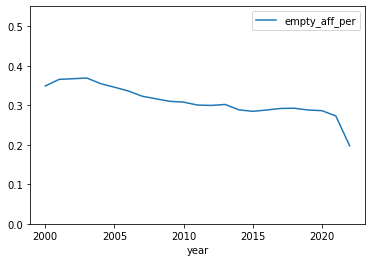

In [22]:
ax = merged_df[merged_df['year'] > 1999].sort_values('year', ascending=False) \
[['year','empty_aff_per']].set_index('year').plot()
ax.set_ylim(0.0, 0.55)

(0.0, 1.0)

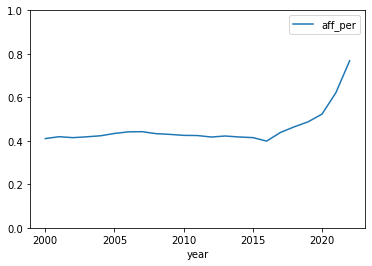

In [18]:
ax = merged_df[merged_df['year'] > 1999].sort_values('year', ascending=False) \
[['year','aff_per']].set_index('year').plot()
ax.set_ylim(0.0, 1.0)

(0.0, 0.25)

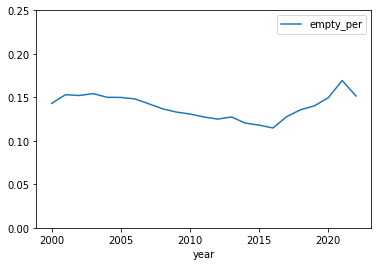

In [20]:
ax = merged_df[merged_df['year'] > 1999].sort_values('year', ascending=False) \
[['year','empty_per']].set_index('year').plot()
ax.set_ylim(0.0, 0.25)

### Looking Into Current Tagging Process (From 1/1/2022 - 5/1/2022)

In [45]:
# Getting full institution table
query = """select affiliation_id, display_name, city, region, country
           from mid.institution"""

In [46]:
cursor.execute("ROLLBACK;")
cursor.execute(query)
df = cursor.fetch_dataframe()
df.shape

(108660, 5)

In [58]:
# sample of papers in 2022 to see how current tagging process is performing
query = """select distinct a.paper_id, a.affiliation_id, a.original_affiliation, b.year
           from (select distinct paper_id, affiliation_id, original_affiliation
                 from mid.affiliation) a
           join (select paper_id, year 
                 from mag_main_papers 
                 where year=2022) b
           on a.paper_id=b.paper_id
           order by RANDOM()
           limit 500"""

In [59]:
cursor.execute("ROLLBACK;")
cursor.execute(query)
curr_aff = cursor.fetch_dataframe()
curr_aff.shape

(500, 4)

In [60]:
curr_aff.to_parquet("current_tagging_sample.parquet")

In [61]:
curr_aff.dropna(subset=['affiliation_id']).shape

(389, 4)

In [62]:
only_tagged = curr_aff.dropna(subset=['affiliation_id']).copy()
only_tagged['affiliation_id'] = only_tagged['affiliation_id'].astype('int')
only_tagged['true_affiliation_id'] = only_tagged['affiliation_id']

In [63]:
only_tagged.columns

Index(['paper_id', 'affiliation_id', 'original_affiliation', 'year',
       'true_affiliation_id'],
      dtype='object')

In [65]:
only_tagged \
[['paper_id','year','true_affiliation_id','affiliation_id', 'original_affiliation']] \
.merge(df[['affiliation_id','display_name','city','region','country']], how='left', on='affiliation_id') \
.to_csv("current_tagging_sample.csv", index=None)

In [66]:
only_tagged[only_tagged['affiliation_id']==186995768]

,paper_id,affiliation_id,original_affiliation,year,true_affiliation_id
25,3197283713,186995768,None,2022,186995768
